<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Современные методы машинного обучения"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: Евгений Рябенко (Senior Data Scientist, Vympelcom, Netherlands)
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора.

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [28]:
data = pd.read_csv('monthly-critical-radio-frequenci.csv',index_col=['month'], parse_dates=['month'], dayfirst=True)

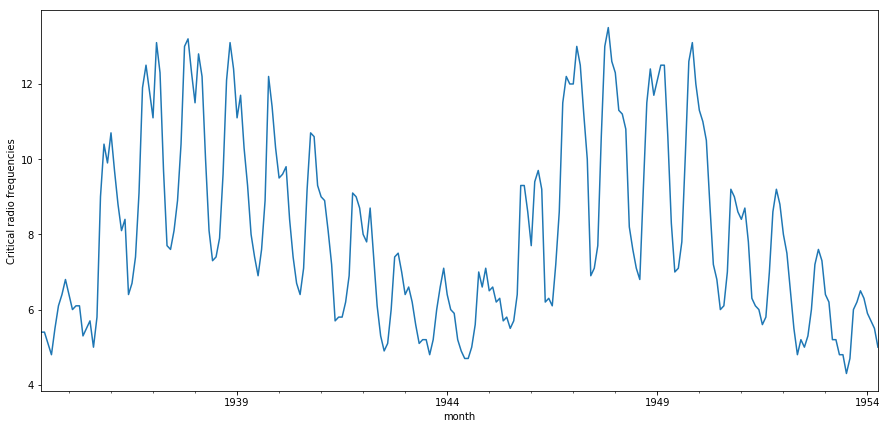

In [29]:
figsize(15,7)
data.rad_freq.plot()
plt.ylabel('Critical radio frequencies')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.249114


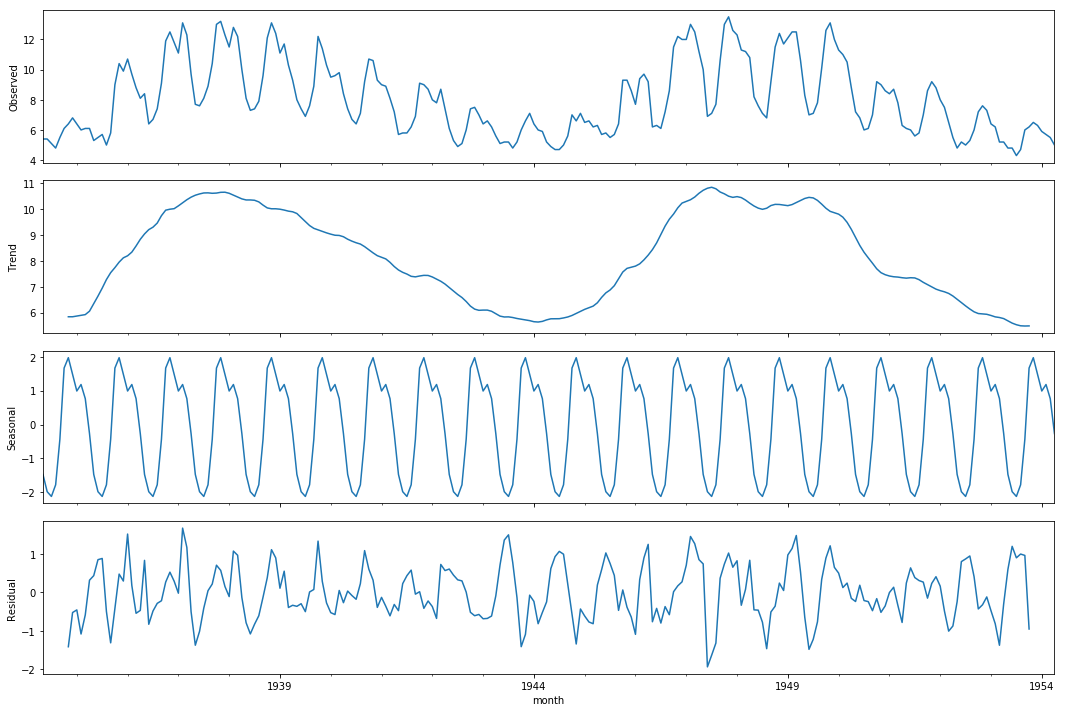

In [30]:
figsize(15,10)
sm.tsa.seasonal_decompose(data.rad_freq).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.rad_freq)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: -0.363429
Критерий Дики-Фуллера: p=0.044311


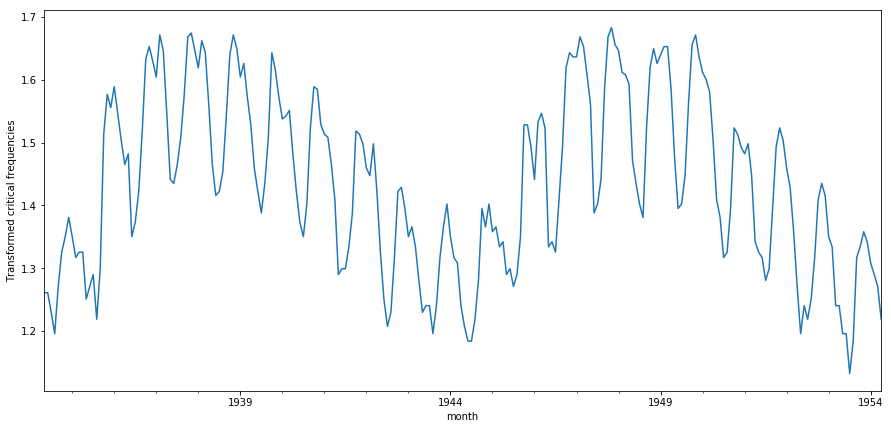

In [23]:
data['freq_box'], lmbda = stats.boxcox(data.rad_freq)
figsize(15,7)
data.freq_box.plot()
plt.ylabel(u'Transformed critical frequencies')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box)[1])

Критерий Дики-Фуллера: p=0.044311


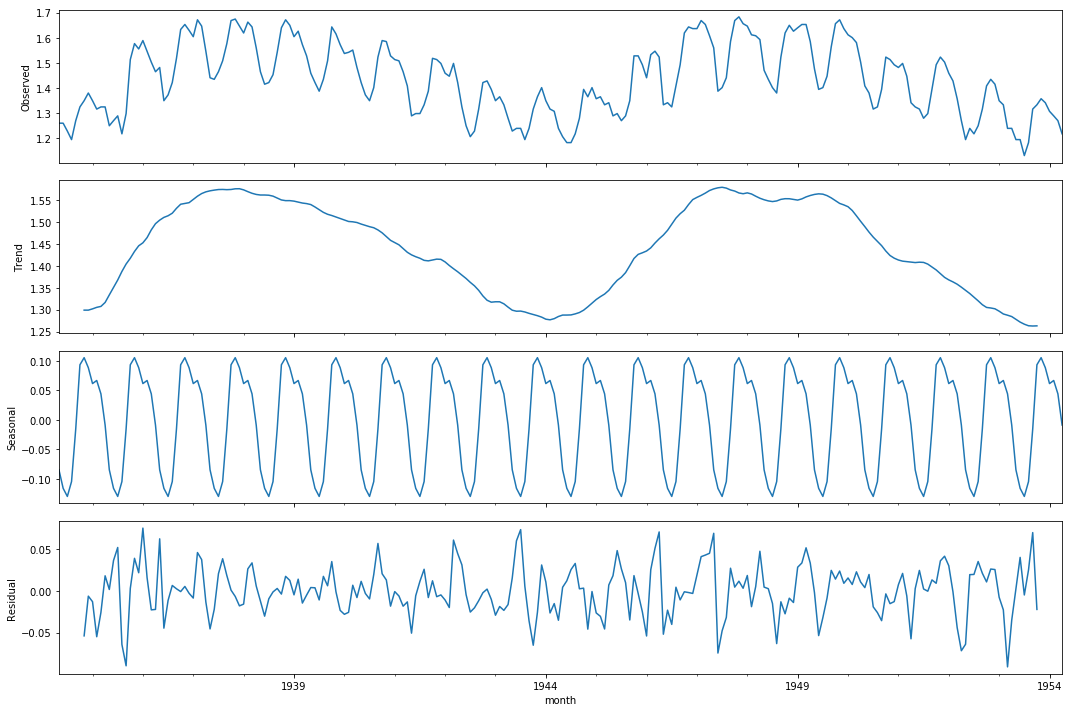

In [24]:
figsize(15,10)
sm.tsa.seasonal_decompose(data.freq_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [31]:
data['freq_box'] = data['rad_freq']

Критерий Дики-Фуллера: p=0.099643


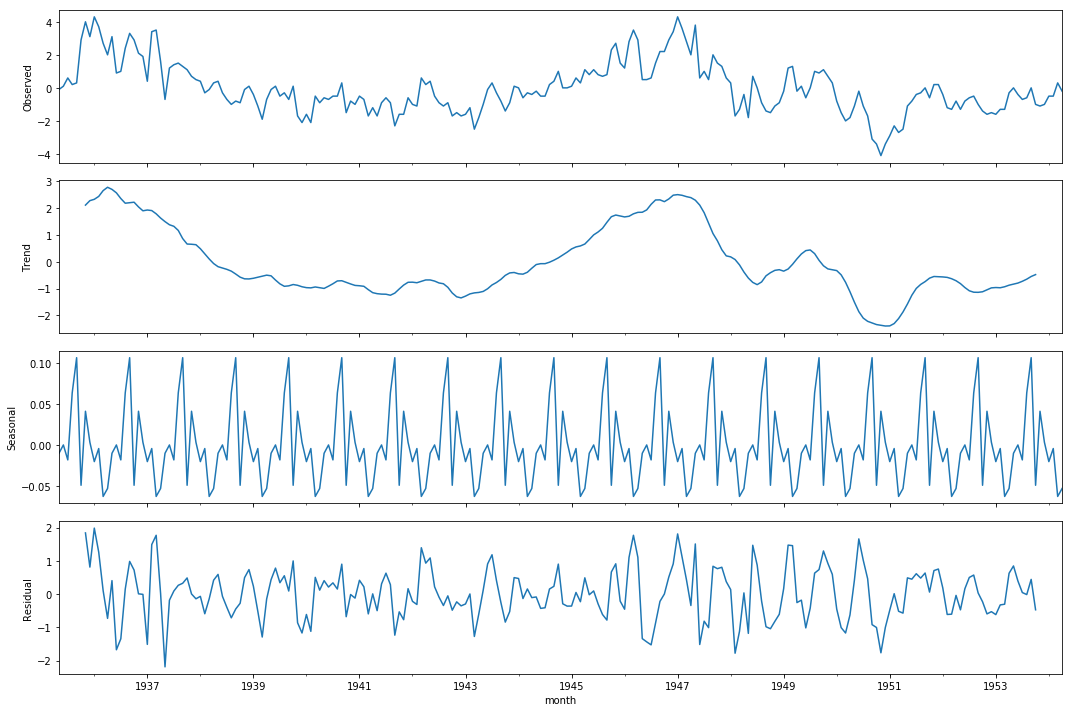

In [32]:
data['freq_box_diff'] = data.freq_box - data.freq_box.shift(12)
sm.tsa.seasonal_decompose(data.freq_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000900


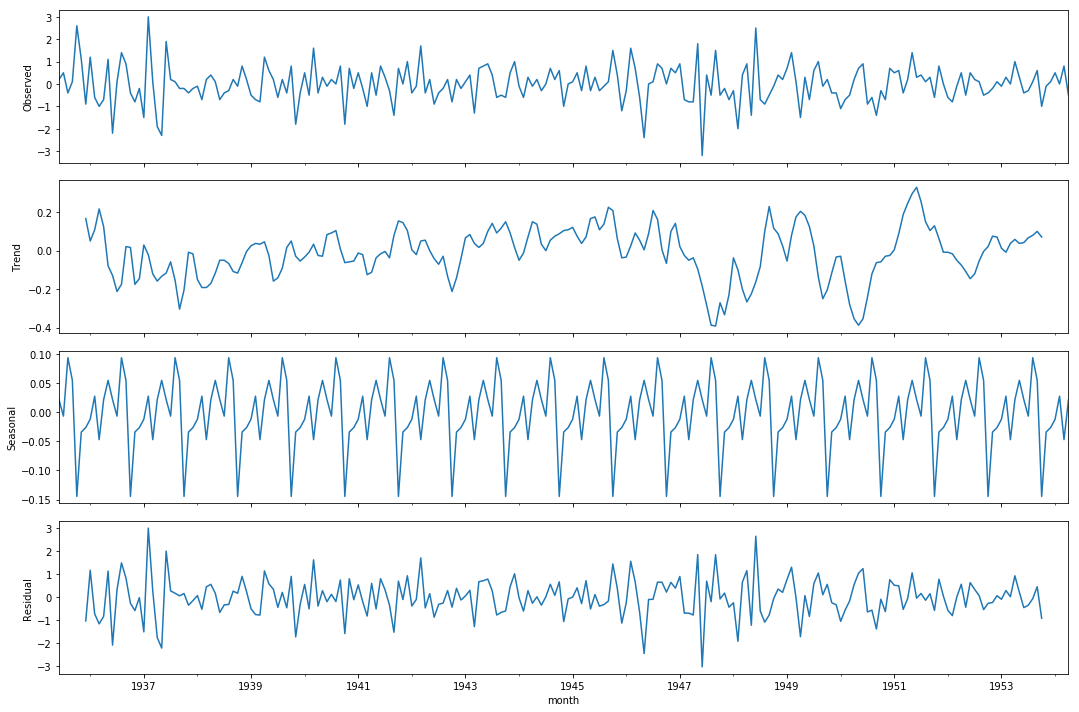

In [33]:
data['freq_box_diff2'] = data.freq_box_diff - data.freq_box_diff.shift(1)
sm.tsa.seasonal_decompose(data.freq_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.freq_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

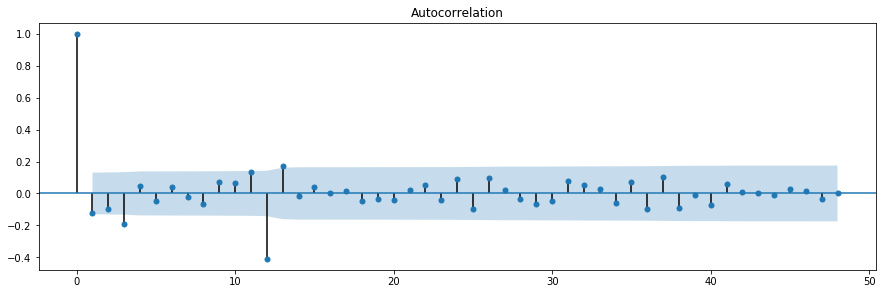

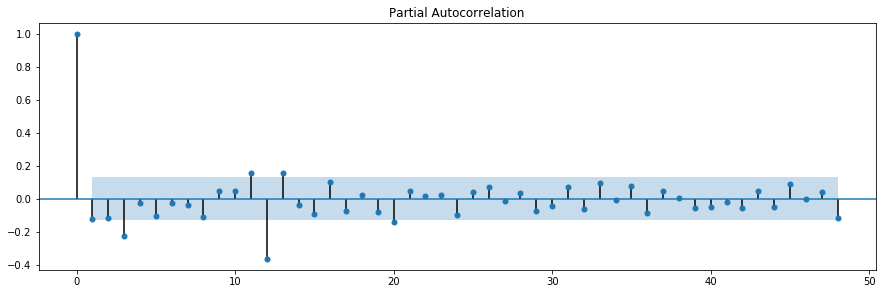

In [34]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.freq_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.freq_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [35]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [36]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [37]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.freq_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 1, 0)
wrong parameters: (1, 1, 1, 1)
CPU times: user 9.27 s, sys: 76 ms, total: 9.35 s
Wall time: 7.85 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [38]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
2   (0, 0, 1, 1)  490.024560
6   (0, 1, 1, 1)  491.987906
10  (1, 0, 1, 1)  491.995083
0   (0, 0, 0, 1)  498.514243
4   (0, 1, 0, 1)  498.763980


Лучшая модель:

In [39]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           freq_box   No. Observations:                  240
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -242.012
Date:                            Wed, 13 Dec 2017   AIC                            490.025
Time:                                    15:37:41   BIC                            500.466
Sample:                                05-01-1934   HQIC                           494.232
                                     - 04-01-1954                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2274      0.105      2.174      0.030       0.022       0.432
ma.S.L12      -0.9988      8.167   

Её остатки:

Критерий Стьюдента: p=0.687358
Критерий Дики-Фуллера: p=0.004121


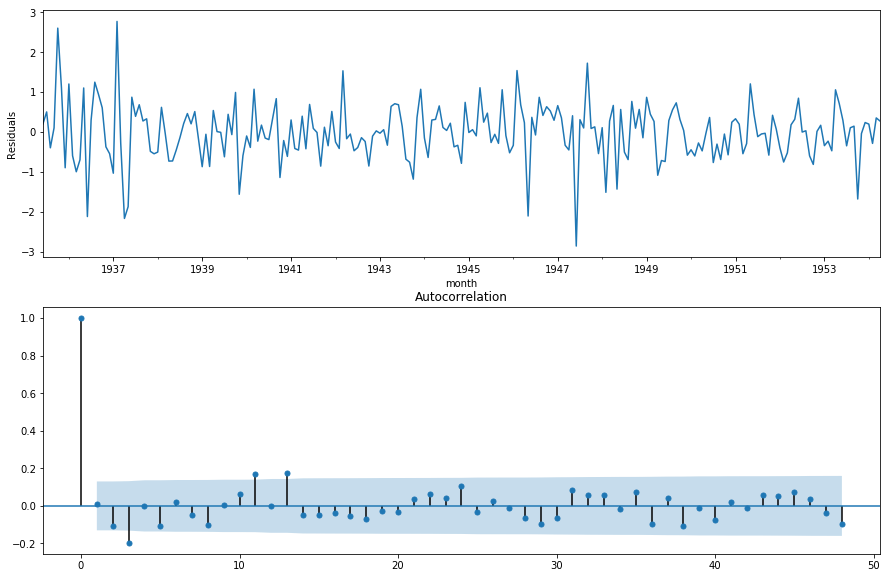

In [40]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

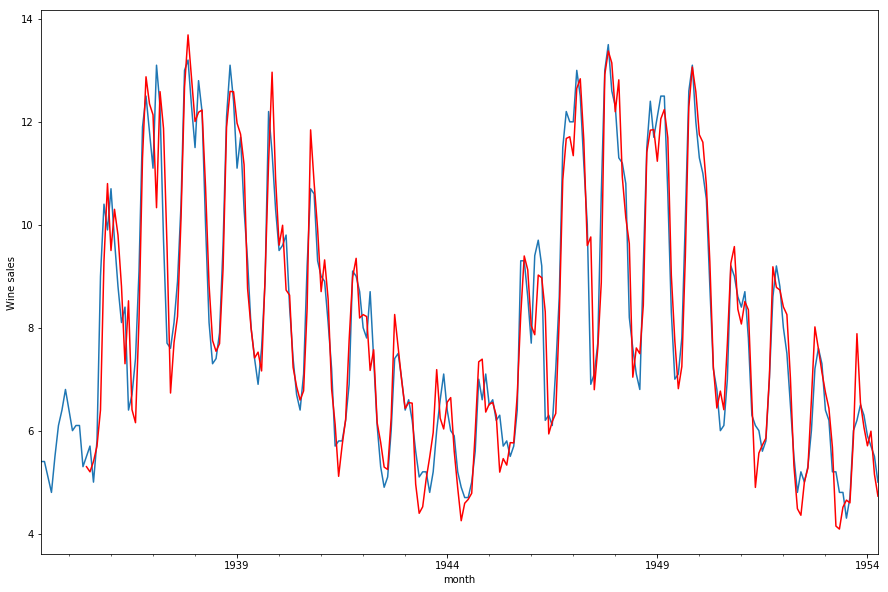

In [41]:
data['model'] = best_model.fittedvalues
data.rad_freq.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

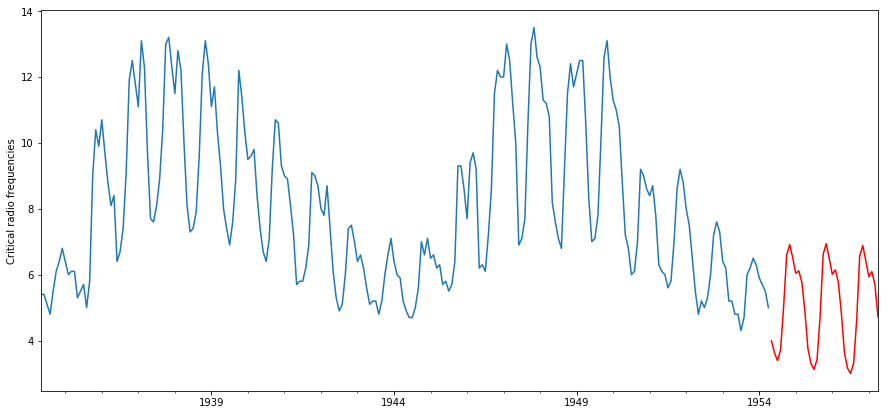

In [47]:

data2 = data[['rad_freq']]
date_list = [datetime.datetime.strptime("1954-05-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = best_model.predict(start=240, end=275)

plt.figure(figsize(15,7))
data2.rad_freq.plot()
data2.forecast.plot(color='r')
plt.ylabel('Critical radio frequencies')
pylab.show()